## Setup environment

In [1]:
import matplotlib.pyplot as plt

from simulators.grid_world.grid_world import Maze, simulate_policy
from simulators.grid_world import GAMMA, HORIZON, COMMANDS

grid_type = "simple"
env = Maze(grid_type)

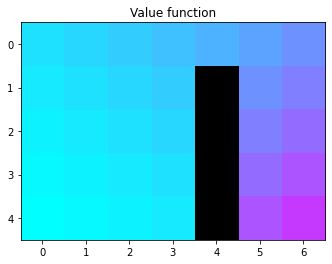

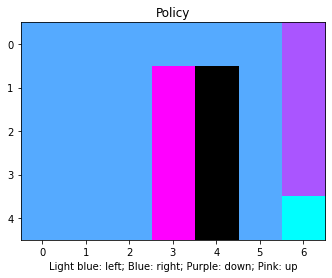

In [2]:
from algorithms.VI_dynamic_programming import value_iteration

expert_Q, expert_policy = value_iteration(env.P, env.R, GAMMA)

# Uncomment if you want to simulate the policy
# simulate_policy(expert_policy, f"../../videos/grid_world/{grid_type}_expert.mp4", env, HORIZON)

expert_V = expert_Q.max(axis=1)
img = env.get_layout_img(expert_V)
plt.title("Value function")    
plt.imshow(img)
plt.show()

plt.figure()
img = env.get_layout_img(expert_policy, min=0, max=3)
plt.title("Policy")
plt.xlabel(COMMANDS)  
plt.imshow(img)
plt.show()

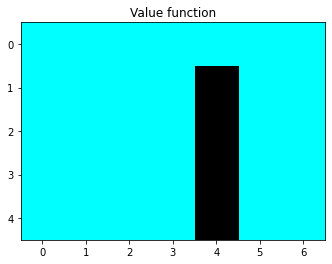

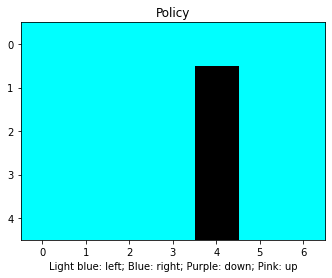

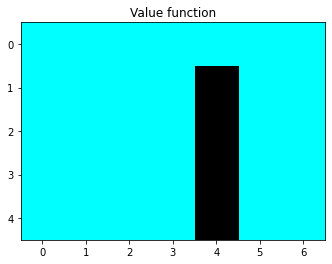

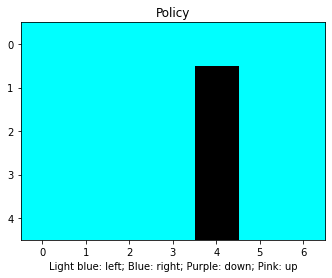

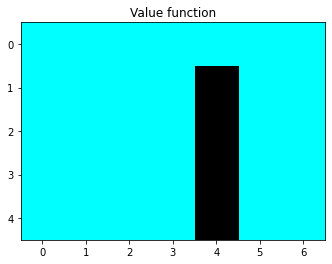

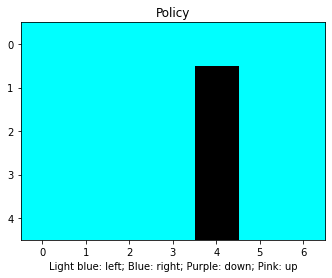

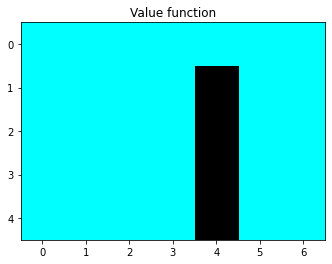

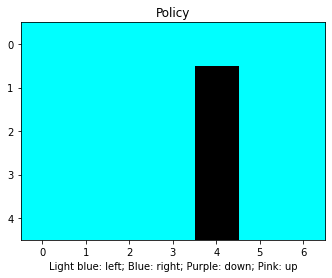

In [8]:
from algorithms.API.lstd import lstd_grid_word

n_expert_samples = 10
n_rl_samples = 10
regularisor = 0.00001
regularisor_bellmann = 0.00001
max_iteration = 4
epsilon_decay_limit = 0.2
regularisor_expert = 1
show_args = {"show_policy":True, "show_value_function": True, "show_statistics": False}

lstd_Q, lstd_policy, buffer_ = lstd_grid_word(env, n_expert_samples, n_rl_samples, regularisor, regularisor_bellmann, max_iteration=max_iteration, epsilon_decay_limit=epsilon_decay_limit, **show_args)

In [4]:
simulate_policy(lstd_policy, f"../../videos/grid_world/{grid_type}_lstd.mp4", env, HORIZON)

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5233:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM default
ffmpeg version 4.3.3-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avres